In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload

%autoreload 2

In [2]:
import os
import sys

sys.path.append('/'.join(os.getcwd().split('/')[:-1]) + '/src/')
#sys.path.append('/'.join(os.getcwd().split('/')[:-1]) + '/src/')

from data import expand_dicts
from features import build_features

In [3]:
df = pd.read_pickle('../data/raw/model_df.pkl')

In [4]:
model_details_df = pd.read_pickle('../data/interim/model_detail_df.pkl')

In [5]:
df = expand_dicts.expand_dict_and_join(df, 'modeler_response')
df = expand_dicts.expand_dict_and_join(df, 'modeler_ratings')

In [6]:
def convert_to_float(o):
    
    if isinstance(o, str):
        o = float(o[:-1])
    elif isinstance(o, int):
        o = float(o)
    return o
    

In [7]:
df.loc[:, 'time'] = df.time.apply(lambda x: convert_to_float(x))

In [9]:
model_details_df

,model_id,geometry,polygons,vertices,unwrapped_uvs,animated,rigged,vr/ar/low-poly,pbr,textures,materials,uv_mapping,plugins_used
0,801556,Subdivision ready,273224,365483,,False,False,True,False,True,True,True,False
1,2095846,Polygon mesh,389886,395824,Unknown,False,False,False,False,True,True,False,True
2,2418972,Polygon mesh,34752,17630,Non-overlapping,False,False,False,False,True,True,True,False
3,2372429,Polygon mesh,236424,241981,No,False,False,False,False,True,True,True,True
4,2251378,Polygon mesh,500000,500000,Mixed,False,False,False,False,True,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
68034,2252178,Polygon mesh,61852,63731,Mixed,False,False,False,False,True,True,True,True
68035,2029813,-,0,0,Unknown,False,False,False,False,True,True,False,True
68036,904538,Polygon mesh,1501,1460,Non-overlapping,False,False,True,False,True,False,True,False
68037,2003192,-,20471,20278,No,False,False,False,False,True,True,True,True


In [10]:
model_details_df = build_features.binarize_columns(model_details_df, ['animated', 'rigged', 'vr/ar/low-poly', 'pbr', 'textures', 'materials', 'uv_mapping', 'plugins_used'])

In [11]:
model_details_df

,model_id,geometry,polygons,vertices,unwrapped_uvs,animated,rigged,vr/ar/low-poly,pbr,textures,materials,uv_mapping,plugins_used
0,801556,Subdivision ready,273224,365483,,0,0,1,0,1,1,1,0
1,2095846,Polygon mesh,389886,395824,Unknown,0,0,0,0,1,1,0,1
2,2418972,Polygon mesh,34752,17630,Non-overlapping,0,0,0,0,1,1,1,0
3,2372429,Polygon mesh,236424,241981,No,0,0,0,0,1,1,1,1
4,2251378,Polygon mesh,500000,500000,Mixed,0,0,0,0,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
68034,2252178,Polygon mesh,61852,63731,Mixed,0,0,0,0,1,1,1,1
68035,2029813,-,0,0,Unknown,0,0,0,0,1,1,0,1
68036,904538,Polygon mesh,1501,1460,Non-overlapping,0,0,1,0,1,0,1,0
68037,2003192,-,20471,20278,No,0,0,0,0,1,1,1,1


In [12]:
combined_df = pd.merge(df, model_details_df, left_index=True, right_index=True)

In [13]:
has_numbers_df = combined_df#[(combined_df.vertices != 0) & (combined_df.polygons != 0)]

In [14]:
from gensim.parsing.preprocessing import preprocess_string

In [15]:
has_numbers_df.loc[:, 'processed'] = has_numbers_df.model_description.apply(lambda x: preprocess_string(x))

In [39]:
pre_model_df = has_numbers_df.drop(['views', 'likes','modeler', 'tags', 'comments', 'model_details', 'model_id', 'geometry', 'price', 'model_description', 'unwrapped_uvs'], axis=1)
pre_model_df.loc[:, 'processed'] = pre_model_df.processed.apply(lambda x: ' '.join(x))

In [ ]:
pre_model_df

In [42]:
pre_model_df.columns

Index(['review_count', 'pic_count', 'price_usd', 'tag_count', 'response_time',
       'percent', 'time', 'avg_rating', 'num_rating', 'polygons', 'vertices',
       'animated', 'rigged', 'vr/ar/low-poly', 'pbr', 'textures', 'materials',
       'uv_mapping', 'plugins_used', 'processed'],
      dtype='object')

In [90]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk


# get text into vector format
X_train, X_test, y_train, y_test = train_test_split(pre_model_df.drop('price_usd',axis=1), pre_model_df.price_usd.values.reshape(-1, 1))

stopwords = nltk.corpus.stopwords.words('english')

In [91]:
#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, max_features=70000,
                                 min_df=.05, stop_words=stopwords,
                                 use_idf=True, tokenizer=build_features.tokenize_and_stem)

tfidf_matrix = tfidf_vectorizer.fit_transform(X_train['processed']) #fit the vectorizer to synopses

In [92]:
test_tfidf_matrix = tfidf_vectorizer.transform(X_test['processed'])

In [71]:
def stack_tfidf_and_df(tfidf_matrix, df):
    tfidf_matrix = tfidf_matrix.todense()
    X = np.hstack((df.drop('processed', axis=1).values, tfidf_matrix))
    return X

In [87]:
X_test

,review_count,pic_count,tag_count,response_time,percent,time,avg_rating,num_rating,polygons,vertices,animated,rigged,vr/ar/low-poly,pbr,textures,materials,uv_mapping,plugins_used,processed
607,0,4,22,0.0,71,0.9,5.0,12,73313,73313,0,0,0,0,0,1,0,0,includ high qualiti furnitur materi textur lig...
680,0,5,8,48.0,14,48.0,4.4,369,240,172,0,0,1,0,1,1,1,0,holli hunt tweed loung chair high qualiti model
108,0,14,18,2.4,100,136.1,0.0,0,0,0,0,0,0,0,0,1,0,0,high detail model creat scene specif materi pl...
716,0,11,14,0.7,73,5.1,4.2,157,2226,1995,0,0,1,0,1,1,1,0,rocket model rocket file creat blender open co...
693,0,5,20,0.8,100,6.6,5.0,10,183908,122590,0,0,0,0,1,1,1,0,mini car easi optim low poli readi game format...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
890,0,2,10,0.7,13,48.0,4.4,35,0,0,0,0,0,0,0,0,0,0,model creat us real world scale model scale re...
158,0,9,14,48.0,50,48.0,4.1,11,5998,7876,0,0,1,1,1,1,1,1,spleen basic content spleen basicpolygon verti...
499,1,15,19,18.6,100,11.8,5.0,14,52412,51732,0,0,0,0,1,1,1,0,low poli cityscap dimens area poli skyscrap bu...
95,0,8,14,0.0,98,1.2,4.9,7,1111,1111,0,0,1,0,1,1,1,0,vacuum infus machin product blender suppli cor...


In [93]:
X_train = stack_tfidf_and_df(tfidf_matrix, X_train)

In [94]:
test_matrix = stack_tfidf_and_df(test_tfidf_matrix, X_test)

In [95]:
tfidf_matrix = tfidf_matrix.todense()

In [96]:
tfidf_matrix.shape

(51029, 149)

In [98]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRFRegressor
from xgboost import XGBRegressor

rf_model = RandomForestRegressor(n_estimators=48, n_jobs=8)
xgbrf_model = XGBRFRegressor()
xgbr_model = XGBRegressor()

In [99]:
rf_model.fit(X_train, y_train)
xgbrf_model.fit(X_train, y_train)
xgbr_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [102]:
def evaluate_regressor(X_test, y_true, model, metric):
    y_preds = model.predict(X_test)
    metric_result = metric(y_true, y_preds)
    return y_preds, metric_result

In [103]:
evaluate_regressor(test_matrix, y_test, rf_model, mean_squared_error)

(array([11.02083333, 57.180625  , 35.        , ..., 48.098125  ,
        22.69979167,  5.16666667]),
 14041.213198842186)

In [104]:
evaluate_regressor(test_matrix, y_test, xgbrf_model, mean_squared_error)

(array([42.81041 , 70.26703 , 43.090176, ..., 20.553698, 19.224085,
        19.224085], dtype=float32),
 8749.928409732498)

In [106]:
evaluate_regressor(test_matrix, y_test, xgbr_model, mean_squared_error)

(array([10.419337, 84.77391 , 36.29622 , ..., 47.463665, 21.531782,
         8.353651], dtype=float32),
 9380.194156749047)

In [56]:
from sklearn.metrics import mean_squared_error

In [57]:
mean_squared_error(y_test, y_preds) ** 0.5

94.1622616761412

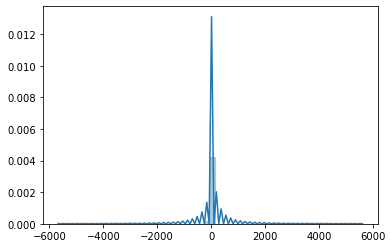

In [58]:
from collections import Counter
import seaborn as sns

c = Counter()

fig, ax = plt.subplots()

#ax.set_xlim(-2000, 2000)

sns.distplot([x[0] for x in (y_test - y_preds.reshape(-1, 1))], ax=ax)

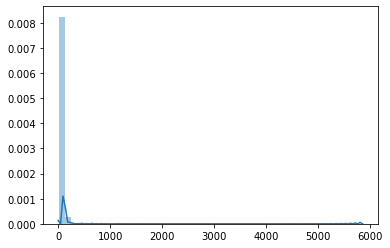

In [60]:
sns.distplot(y_preds)

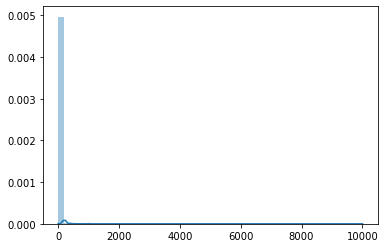

In [59]:
sns.distplot(y_test)

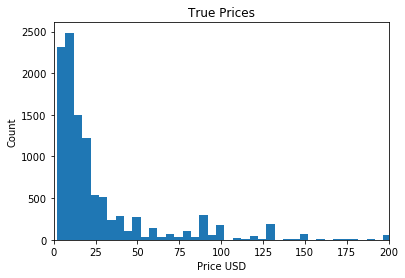

In [130]:
fig, ax = plt.subplots()

ax.hist([x[0] for x in y_test], bins=2000);
ax.set_xlim(0, 200)
ax.set_xlabel('Price USD')
ax.set_ylabel('Count')
ax.set_title('True Prices');

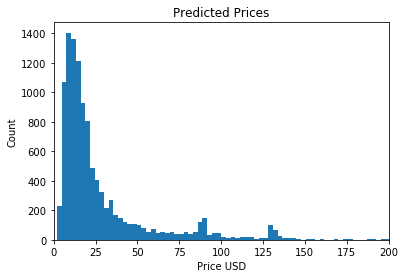

In [131]:
fig, ax = plt.subplots()

ax.hist([x[0] for x in y_preds.reshape(-1, 1)], bins=2000);
ax.set_xlim(0, 200)
ax.set_xlabel('Price USD')
ax.set_ylabel('Count')
ax.set_title('Predicted Prices');

In [88]:
abs_errors = np.array([x[0] for x in abs(y_test - y_preds.reshape(-1, 1))])

(0, 200)

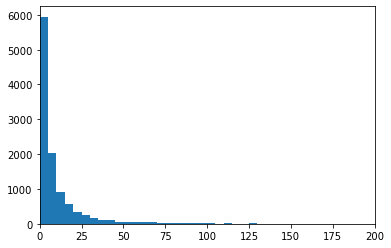

In [122]:
fig, ax = plt.subplots()

ax.hist(abs_errors, bins=2000);
ax.set_xlim(0, 200)

In [128]:
mean_squared_error(y_test.reshape(1, -1)[0], y_preds) ** 0.5

119.54019159149311

In [135]:
X_test[abs_errors < 1].processed

591    marbl floor manufactur yurtbai collect invis m...
592    model flower cornflow model cortina minim numb...
103    product interior collect item furnitur light b...
817    product interior collect item furnitur light b...
222    model craft attent textur includ come vrai sta...
                             ...                        
317    bitmap procedur base shader color map specular...
714    characterist model contain histor record actua...
480                                         softwar dmax
351    game readi pbr textur optim metal us pbr real ...
640    dodg challeng shaker fly creator team model ch...
Name: processed, Length: 2633, dtype: object

In [93]:
X_test[abs_errors < 5].describe()

,views,likes,review_count,pic_count,tag_count,response_time,percent,time,avg_rating,num_rating,polygons,vertices,animated,rigged,vr/ar/low-poly,pbr,textures,materials,uv_mapping,plugins_used
count,5946.000000,5946.000000,5946.000000,5946.000000,5946.000000,5946.000000,5946.000000,5946.00000,5946.000000,5946.000000,5.946000e+03,5.946000e+03,5946.000000,5946.000000,5946.000000,5946.000000,5946.000000,5946.000000,5946.000000,5946.000000
mean,464.710562,0.962496,0.046586,8.041372,15.439623,28.762916,59.411705,16.79186,3.559738,49.560377,8.524346e+05,3.455708e+06,0.035991,0.101076,0.299697,0.193071,0.839051,0.882947,0.751934,0.275816
std,759.073476,3.424167,0.281799,9.668081,5.698875,185.850810,36.586660,94.44066,1.996642,96.541536,1.066737e+07,1.001620e+08,0.186282,0.301455,0.458164,0.394741,0.367514,0.321511,0.431927,0.446962
min,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000e+00,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.000000,0.000000,0.000000,3.000000,11.000000,0.200000,27.000000,0.30000,3.100000,1.000000,5.616000e+03,5.104000e+03,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
50%,211.000000,0.000000,0.000000,6.000000,16.000000,3.100000,73.000000,1.70000,4.700000,8.000000,3.364900e+04,2.595200e+04,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
75%,599.000000,1.000000,0.000000,10.000000,20.000000,47.000000,89.000000,9.10000,5.000000,39.000000,2.130080e+05,1.558750e+05,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000
max,14800.000000,110.000000,6.000000,133.000000,95.000000,5614.600000,100.000000,1731.80000,5.000000,550.000000,3.453453e+08,3.453453e+09,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [95]:
X_test[abs_errors >= 5].describe()

,views,likes,review_count,pic_count,tag_count,response_time,percent,time,avg_rating,num_rating,polygons,vertices,animated,rigged,vr/ar/low-poly,pbr,textures,materials,uv_mapping,plugins_used
count,5026.000000,5026.000000,5026.000000,5026.000000,5026.000000,5026.000000,5026.000000,5026.000000,5026.000000,5026.000000,5.026000e+03,5.026000e+03,5026.000000,5026.000000,5026.000000,5026.000000,5026.000000,5026.000000,5026.000000,5026.000000
mean,811.179268,2.739156,0.188221,12.418424,15.623160,21.870056,59.221051,18.284322,3.507461,47.630521,1.324553e+06,7.487128e+06,0.042778,0.096299,0.311381,0.202348,0.832073,0.877835,0.755273,0.273776
std,1433.944745,9.076404,0.865933,17.335903,5.670913,180.799095,36.865277,105.697324,2.031299,96.158202,1.601774e+07,1.539411e+08,0.202375,0.295031,0.463104,0.401790,0.373838,0.327509,0.429968,0.445940
min,1.000000,0.000000,0.000000,1.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+00,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,94.000000,0.000000,0.000000,5.000000,11.000000,0.100000,27.000000,0.300000,2.500000,1.000000,4.934000e+03,4.456500e+03,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
50%,338.000000,1.000000,0.000000,9.000000,16.000000,1.600000,73.000000,1.700000,4.600000,8.000000,3.000000e+04,2.375400e+04,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
75%,981.750000,2.000000,0.000000,14.000000,20.000000,10.675000,90.000000,9.100000,5.000000,37.000000,2.152140e+05,1.602000e+05,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000
max,33900.000000,221.000000,23.000000,628.000000,73.000000,7107.400000,100.000000,1731.800000,5.000000,550.000000,3.453453e+08,3.453453e+09,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [67]:
(y_preds - y_test)[0]

array([ 13.1949, -14.4027,  -7.25  , ...,  -6.6809, 109.    , -11.4117])

In [54]:
model.feature_importances_

array([2.30761495e-02, 1.01336057e-02, 1.20479067e-02, ...,
       8.92984420e-05, 8.16235976e-06, 2.11537297e-05])

In [47]:
model_details_df['unwrapped_uvs'].value_counts()

Unknown            25379
Non-overlapping    15048
                   11494
Mixed               8206
Overlapping         3982
No                  3930
Name: unwrapped_uvs, dtype: int64

In [48]:
unwrapped_uv_lookup = {
    'Unknown': 'Unknown',
    'Non-overlapping': 'Non-overlapping',
    '' : 'Unknown',
    'Mixed': 'Mixed',
    'Overlapping':'Overlapping',
    'No':'No'
}

model_details_df.loc[:, 'unwrapped_uvs'] = model_details_df['unwrapped_uvs'].apply(lambda x: unwrapped_uv_lookup[x])

In [49]:
from collections import defaultdict

In [50]:
geometry_lookup = defaultdict(lambda:'Other')

geometry_lookup.update({
    'Polygon mesh': 'Polygon mesh',
    'Subdivision ready': 'Subdivision ready',
    'Subdivision': 'Subdivision'
})

In [51]:
model_details_df['geometry'].value_counts()

Polygon mesh            50481
-                       12657
Subdivision ready        1630
Subdivision              1572
Other                    1153
Nurbs                     243
Polygon                   181
Choose Geometry           111
                            5
Выбрать геометрию           2
选择几何                        2
Odaberite Geometriju        1
Elige La Geometría          1
Name: geometry, dtype: int64

In [52]:
model_details_df.loc[:,'geometry'] = model_details_df['geometry'].apply(lambda x: geometry_lookup[x])

In [54]:
df.corr()

,views,likes,review_count,pic_count,price_usd,tag_count,response_time,percent,avg_rating,num_rating
views,1.000000,0.493786,0.440675,0.054247,0.065418,0.057925,0.009589,0.001646,-0.000119,0.006730
likes,0.493786,1.000000,0.571078,0.116301,0.038109,0.051500,-0.013262,-0.001861,0.000043,0.002420
review_count,0.440675,0.571078,1.000000,0.046703,0.002775,0.015852,-0.007185,-0.001116,-0.000017,0.004235
pic_count,0.054247,0.116301,0.046703,1.000000,0.077719,0.168018,-0.026727,-0.003783,-0.006416,-0.005451
price_usd,0.065418,0.038109,0.002775,0.077719,1.000000,0.043365,-0.005331,-0.004245,0.002563,-0.001747
tag_count,0.057925,0.051500,0.015852,0.168018,0.043365,1.000000,-0.038327,0.003810,-0.002494,-0.002062
response_time,0.009589,-0.013262,-0.007185,-0.026727,-0.005331,-0.038327,1.000000,-0.001713,-0.008623,-0.003953
percent,0.001646,-0.001861,-0.001116,-0.003783,-0.004245,0.003810,-0.001713,1.000000,0.008274,0.007327
avg_rating,-0.000119,0.000043,-0.000017,-0.006416,0.002563,-0.002494,-0.008623,0.008274,1.000000,0.267297
num_rating,0.006730,0.002420,0.004235,-0.005451,-0.001747,-0.002062,-0.003953,0.007327,0.267297,1.000000


In [28]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer


def remove_urls(text):
    text = re.sub(r'http\S+', '', text)
    return text


#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.9, max_features=200000,
                                 min_df=0.1, stop_words=stopwords,
                                 use_idf=True, tokenizer=tokenize_and_lemma, ngram_range=(1,3))

tfidf_matrix = tfidf_vectorizer.fit_transform(df.model_description.values)

def text_pipeline(df, text_col):
    no_urls = df[text_col].apply(lambda x: remove_urls(x))
    res = map(lambda x: build_features.tokenize_and_lemma(x.lower()), no_urls)
    return res
    

def pipeline(df, target_col, estimator, metric):
    X_train, X_test, y_train, y_test = train_test_split(df.drop(target_col, axis=1), df[target_col])
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    return metric(y_pred, y_test, estimator)

In [15]:
list(text_pipeline(df, 'model_description'))

[['high',
  'quality',
  '3d',
  'model',
  'of',
  'barazza',
  'the',
  'model',
  'are',
  'made',
  'with',
  'much',
  'attention',
  'to',
  'detail',
  'they',
  'have',
  'reasonable',
  'amount',
  'of',
  'polygon',
  'and',
  'accurate',
  'grid',
  'cod',
  '1lfs81d',
  'sink',
  'cod',
  '1lfs82',
  'sink',
  'cod',
  '1lfs91d',
  'sink',
  'cod',
  '1lfs92',
  'sink',
  'cod',
  '1lfs10d',
  'sink',
  'cod',
  '1lfs12d',
  'sink',
  'cod',
  '1lfs82a',
  'sink',
  'cod',
  '1ci33',
  'accessorie',
  'geometry',
  'polygonal',
  'quad',
  'only',
  'turbosmooth',
  'iterations=0',
  'polys',
  'verts',
  'all',
  'model',
  'turbosmooth',
  'iterations=1',
  'polys',
  'verts',
  'all',
  'model'],
 ['this',
  '3d',
  'model',
  'lipende',
  'sofa',
  'ha',
  'a',
  'fully',
  'textured',
  'detailed',
  'design',
  'that',
  'allows',
  'for',
  'close-up',
  'render',
  'every',
  'model',
  'ha',
  'been',
  'checked',
  'with',
  'the',
  'appropriate',
  'software',
 

In [45]:
modeler_ohe.transform(df['modeler'].values.reshape(-1, 1))

<68039x11734 sparse matrix of type '<class 'numpy.float64'>'
	with 68039 stored elements in Compressed Sparse Row format>

In [21]:
df.columns

Index(['modeler', 'modeler_response', 'modeler_ratings', 'tags', 'views',
       'likes', 'review_count', 'comments', 'price', 'pic_count',
       'model_description', 'model_details', 'price_usd', 'tag_count',
       'response_time'],
      dtype='object')

In [28]:
from src.data import expand_dicts

ModuleNotFoundError: No module named 'src'

In [22]:
combined_df = pd.merge(df, model_details_df, left_index=True, right_index=True)

In [23]:
combined_df['modeler_response_time']

,modeler,modeler_response,modeler_ratings,tags,views,likes,review_count,comments,price,pic_count,...,vertices,unwrapped_uvs,animated,rigged,vr/ar/low-poly,pbr,textures,materials,uv_mapping,plugins_used
0,andriy115599,"{'percent': 100, 'time': '5.0h'}","{'avg_rating': 3.9, 'num_rating': 14}","[accessorie, appliance, barazza, furniture, ki...",351,0,0,"{'authors': [], 'texts': [], 'datetimes': []}",$6.00,30,...,365483,,False,False,True,False,True,True,True,False
0,BurakSimsek,"{'percent': 75, 'time': '324.3h'}","{'avg_rating': 5.0, 'num_rating': 1}","[bathroom, bath, wc, accessory, accessoires, l...",493,0,0,"{'authors': [], 'texts': [], 'datetimes': []}",$28.00,2,...,365483,,False,False,True,False,True,True,True,False
0,vilmorin,"{'percent': 100, 'time': '5.4h'}","{'avg_rating': 0, 'num_rating': 0}","[interior, decorate, plants, plant, leaf, indoor]",170,0,0,"{'authors': [], 'texts': [], 'datetimes': []}",$4.00,2,...,365483,,False,False,True,False,True,True,True,False
0,CGRoom,"{'percent': 0, 'time': 0}","{'avg_rating': 0, 'num_rating': 0}","[rimadesio, tray, gray, marble, wood, walnut, ...",103,1,0,"{'authors': [], 'texts': [], 'datetimes': []}",$12.00,6,...,365483,,False,False,True,False,True,True,True,False
0,BTStockStudio,"{'percent': 0, 'time': '48.0h'}","{'avg_rating': 0, 'num_rating': 0}","[chicken, turkey, leg, food, meat, animal, bir...",43,1,0,"{'authors': [], 'texts': [], 'datetimes': []}",$4.00,5,...,365483,,False,False,True,False,True,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999,Polygonal-Miniatures,"{'percent': 95, 'time': '0.3h'}","{'avg_rating': 5.0, 'num_rating': 550}","[360, panorama, 4096, hdri, hdr, image, skybox...",1760,1,2,"{'authors': [], 'texts': [], 'datetimes': []}",$59.95,20,...,500000,Unknown,False,False,False,False,True,True,False,False
999,MMW,"{'percent': 27, 'time': '48.0h'}","{'avg_rating': 3.1, 'num_rating': 8}","[glass, table, coffee, wine, water, beer, soda...",892,1,0,"{'authors': ['piyushp7879'], 'texts': ['Good']...",$4.00,5,...,500000,Unknown,False,False,False,False,True,True,False,False
999,antonyurevich,"{'percent': 0, 'time': 0}","{'avg_rating': 5.0, 'num_rating': 1}","[henry, exposed, wall, mounted, tub, filler, w...",51,1,0,"{'authors': [], 'texts': [], 'datetimes': []}",$7.00,3,...,500000,Unknown,False,False,False,False,True,True,False,False
999,alexandr33d,"{'percent': 100, 'time': '2.7h'}","{'avg_rating': 5.0, 'num_rating': 11}","[rock, cliff, pbr, facade, environment, mounta...",357,1,0,"{'authors': [], 'texts': [], 'datetimes': []}",$18.00,6,...,500000,Unknown,False,False,False,False,True,True,False,False


In [20]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

In [ ]:
cat_columns = [0, 3, 4, 5, 6, 8, 9, 11, 12]
cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))])

num_columns = [1, 2, 7, 10, 13, 14]
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=-1))])

# And put all those pipelines inside a ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('cat', cat_pipeline, cat_columns),
    ('num', num_pipeline, num_columns)])

In [19]:
model_details_df.unwrapped_uvs.value_counts()

Unknown            25379
Non-overlapping    15048
                   11494
Mixed               8206
Overlapping         3982
No                  3930
Name: unwrapped_uvs, dtype: int64

In [60]:
import nltk
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer('\w+')#'|\(\d+\*\d+\)|\(\d+.\d+,\d+\)')

In [61]:
regexed = []

for desc in list(df.model_description):
    regexed.append([x.lower() for x in tokenizer.tokenize(desc)])

In [62]:
rejoined_sents = [' '.join(x) for x in regexed]

In [63]:
rejoined_sents[0:2]

['high quality 3d models of barazza the models are made with much attention to details they have reasonable amount of polygons and accurate grid cod 1lfs81d 500 790 sinks cod 1lfs82 500 790 sinks cod 1lfs91d 500 860 sinks cod 1lfs92 500 860 sinks cod 1lfs10d 500 1000 sinks cod 1lfs12d 500 1160 sinks cod 1lfs82a 830 830 sinks cod 1ci33 403 346 5 accessorie geometry polygonal quads only turbosmooth iterations 0 polys 273 224 verts 365 483 all models turbosmooth iterations 1 polys 2 163 038 verts 1 245 905 all models',
 'this 3d model lipende sofa has a fully textured detailed design that allows for close up renders every model has been checked with the appropriate software polygons 389886 vertices 395824 formats 3ds max 2014 obj fbx 3ds hope you like it also check out my other models just click on my user name to see complete gallery']

In [142]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer (max_features=2500, min_df=.1, max_df=0.8, stop_words=stopwords.words('english'))
processed_features = vectorizer.fit_transform(rejoined_sents).toarray()

In [143]:
rf = RandomForestRegressor()

In [144]:
df['cleaned_text'] = rejoined_sents

In [146]:
pd.concat(df.drop(['modeler', 'modeler_response', 'modeler_ratings', 'tags', 'comments', 'model_description', 'price', 'model_details', 'response_time'], axis=1))

TypeError: first argument must be an iterable of pandas objects, you passed an object of type "DataFrame"

In [101]:
import gensim.downloader as api

wv = api.load('word2vec-google-news-300')

def get_avg(phrase, wv):
    vec_result = []
    tokens = phrase.split(' ')    
    for t in tokens:
        if t in wv:
            vec_result.append(wv[t].tolist())
        else:
            #300 is the dimension of the Google wv model
            vec_result.append([0.0]*300)    
    return np.average(vec_result, axis=0)

get_avg('this 3d model sofa has a fully textured detailed design', wv)

In [85]:
np.quantile(df['price_usd'], [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

array([4.750e+00, 6.000e+00, 8.000e+00, 1.000e+01, 1.448e+01, 1.899e+01,
       2.414e+01, 3.900e+01, 8.900e+01, 1.000e+04])

In [136]:
price_df = df[df['price_usd'] < 100]

In [137]:
X = np.array([get_avg(phrase, wv) for phrase in price_df['model_description']])
y = np.array(price_df['price_usd'])

In [135]:
from sklearn.ensemble import RandomForestRegressor

# baseline including zero parameters
reg = RandomForestRegressor(random_state=0, max_depth=5, n_jobs=8)

from gensim.test.utils import common_texts
from gensim.models import Phrases

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

#10-fold cross validation
kf = KFold(n_splits=10)
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]    
    reg.fit(X_train, y_train)
    
    print(mean_squared_error(y_test, reg.predict(X_test)) ** 0.5)

<bound method RegressorMixin.score of RandomForestRegressor(random_state=0)>

In [59]:
from textblob import TextBlob

In [60]:
example_blob = TextBlob(list(df.model_description)[0])

In [64]:
example_blob.pos_tags

[('High', 'JJ'),
 ('quality', 'NN'),
 ('3d', 'CD'),
 ('models', 'NNS'),
 ('of', 'IN'),
 ('Barazza', 'NNP'),
 ('The', 'DT'),
 ('models', 'NNS'),
 ('are', 'VBP'),
 ('made', 'VBN'),
 ('with', 'IN'),
 ('much', 'JJ'),
 ('attention', 'NN'),
 ('to', 'TO'),
 ('details', 'NNS'),
 ('They', 'PRP'),
 ('have', 'VBP'),
 ('reasonable', 'JJ'),
 ('amount', 'NN'),
 ('of', 'IN'),
 ('polygons', 'NNS'),
 ('and', 'CC'),
 ('accurate', 'JJ'),
 ('grid', 'NN'),
 ('cod', 'NN'),
 ('1LFS81D', 'CD'),
 ('500', 'CD'),
 ('*', 'RB'),
 ('790', 'CD'),
 ('sinks', 'NNS'),
 ('cod', 'VBP'),
 ('1LFS82', 'CD'),
 ('500', 'CD'),
 ('*', 'RB'),
 ('790', 'CD'),
 ('sinks', 'NNS'),
 ('cod', 'VBP'),
 ('1LFS91D', 'CD'),
 ('500', 'CD'),
 ('*', 'RB'),
 ('860', 'CD'),
 ('sinks', 'NNS'),
 ('cod', 'VBP'),
 ('1LFS92', 'CD'),
 ('500', 'CD'),
 ('*', 'RB'),
 ('860', 'CD'),
 ('sinks', 'NNS'),
 ('cod', 'VBP'),
 ('1LFS10D', 'CD'),
 ('500', 'CD'),
 ('*', 'RB'),
 ('1000', 'CD'),
 ('sinks', 'NNS'),
 ('cod', 'VBP'),
 ('1LFS12D', 'CD'),
 ('500', 'CD'),

In [61]:
example_blob.noun_phrases

WordList(['high quality 3d models', 'barazza', 'reasonable amount', 'accurate grid', 'sinks cod', 'sinks cod', 'sinks cod', 'sinks cod', 'sinks cod', 'sinks cod', 'sinks cod', 'geometry', 'polygonal quads', 'turbosmooth', 'polys', 'verts', 'turbosmooth', 'polys', 'verts'])

In [5]:
blobs = []

for x in df.model_description:
    blobs.append(TextBlob(x))

In [6]:
polarities = []

for blob in blobs:
    polarities.append(blob.polarity)

(array([7.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00, 3.0000e+00,
        5.1000e+01, 1.2000e+01, 2.4000e+01, 0.0000e+00, 1.2000e+01,
        1.7000e+01, 2.0000e+00, 3.9000e+01, 1.4000e+01, 2.0000e+01,
        3.2000e+02, 1.2100e+02, 1.1500e+02, 1.7900e+02, 3.2400e+02,
        2.6000e+02, 6.1600e+02, 9.4900e+02, 1.0400e+03, 1.8280e+03,
        1.5743e+04, 3.7590e+03, 5.4970e+03, 7.1120e+03, 6.8620e+03,
        6.8310e+03, 4.1770e+03, 3.9630e+03, 2.0520e+03, 2.5200e+03,
        1.0240e+03, 6.4400e+02, 6.4500e+02, 3.6000e+02, 1.8600e+02,
        7.9000e+01, 6.6000e+01, 2.2500e+02, 4.2000e+01, 1.9000e+01,
        4.6000e+01, 5.5000e+01, 2.8000e+01, 1.0000e+00, 1.4800e+02]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56

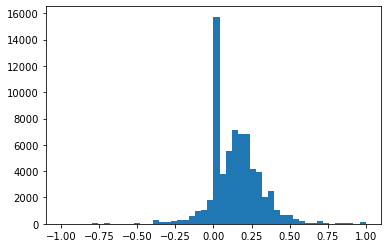

In [10]:
plt.hist(polarities, bins=50)

In [15]:
np.array(blobs)[np.array(polarities) < -.45]

array([TextBlob("Restoration Hardware Dixon Upholstered Base Leather Armchair https://www.restorationhardware.com/catalog/product/product.jsp?productId=prod17510046&categoryId=search V-Ray render and materials All textures include in *.rar files Lighting setup is not included in the file "),
       TextBlob("2301CarpenterSofaC3seats_2280x974x1020 2638100F Fabric JY5680-3 2638800F Fabric ST9-4 230-1 Carpenter Sofa C 3-seats 2280x974x1020Polys: 59547 Verts: c "),
       TextBlob("Product: Tika lantern steel base Materials: HDPE wicker | powder coated aluminium frame | steel base Dimensions: 59 cm x 35 cm "),
       TextBlob("Please let me know before making bad comments for mistakes and problems so l can fix them. And please do not hesitate to ask questions.   In the format ztl (Zbrush)Separately hair,body,dress  "),
       TextBlob("army jeep 3d model with 2k and 4k pbr textures.made in 3d max 2014 and render in marmoset toolbag. model characteristics: .quad based topology .uv unwrapped

In [126]:
import numpy as np

np.array(blobs)[np.array(polarities) < -0.5]

array([TextBlob("Restoration Hardware Dixon Upholstered Base Leather Armchair https://www.restorationhardware.com/catalog/product/product.jsp?productId=prod17510046&categoryId=search V-Ray render and materials All textures include in *.rar files Lighting setup is not included in the file "),
       TextBlob("2301CarpenterSofaC3seats_2280x974x1020 2638100F Fabric JY5680-3 2638800F Fabric ST9-4 230-1 Carpenter Sofa C 3-seats 2280x974x1020Polys: 59547 Verts: c "),
       TextBlob("Product: Tika lantern steel base Materials: HDPE wicker | powder coated aluminium frame | steel base Dimensions: 59 cm x 35 cm "),
       TextBlob("Please let me know before making bad comments for mistakes and problems so l can fix them. And please do not hesitate to ask questions.   In the format ztl (Zbrush)Separately hair,body,dress  "),
       TextBlob("army jeep 3d model with 2k and 4k pbr textures.made in 3d max 2014 and render in marmoset toolbag. model characteristics: .quad based topology .uv unwrapped

(array([1.2000e+01, 9.9000e+01, 3.8800e+02, 7.6300e+02, 4.6930e+03,
        4.0493e+04, 1.8023e+04, 2.8590e+03, 4.3100e+02, 2.7800e+02]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

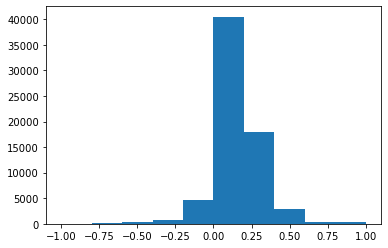

In [119]:
plt.hist(polarities)

In [100]:
example_blob.noun_phrases

WordList(['high quality 3d models', 'barazza', 'reasonable amount', 'accurate grid', 'sinks cod', 'sinks cod', 'sinks cod', 'sinks cod', 'sinks cod', 'sinks cod', 'sinks cod', 'geometry', 'polygonal quads', 'turbosmooth', 'polys', 'verts', 'turbosmooth', 'polys', 'verts'])

In [89]:
df.model_description.apply(lambda x: TextBlob(x).tags)

KeyboardInterrupt: 

In [3]:
df

,modeler,modeler_response,modeler_ratings,tags,views,likes,review_count,comments,price,pic_count,model_description,model_details,price_usd,tag_count,response_time
0,andriy115599,"{'percent': 100, 'time': '5.0h'}","{'avg_rating': 3.9, 'num_rating': 14}","[accessorie, appliance, barazza, furniture, ki...",351,0,0,"{'authors': [], 'texts': [], 'datetimes': []}",$6.00,30,High quality 3d models of Barazza. The models ...,"{'model_id': '801556', 'geometry': 'Subdivisio...",6.00,7,5.0
1,sinartur,"{'percent': 0, 'time': 0}","{'avg_rating': 0, 'num_rating': 0}","[bed, furniture, pillow, comfort, modern, styl...",96,1,0,"{'authors': ['GGAF'], 'texts': ['cool'], 'date...",$14.99,10,This 3d model Lipende sofa has a fully texture...,"{'model_id': '2095846', 'geometry': 'Polygon m...",14.99,19,0.0
2,hq3dmodel,"{'percent': 0, 'time': 0}","{'avg_rating': 5.0, 'num_rating': 1}","[rug, carpet, fur, interior, floor, cloth, woo...",15,0,0,"{'authors': [], 'texts': [], 'datetimes': []}",$5.00,8,The set consists of 3 rugs. All high quality t...,"{'model_id': '2418972', 'geometry': 'Polygon m...",5.00,20,0.0
3,-snake-,"{'percent': 0, 'time': 0}","{'avg_rating': 0, 'num_rating': 0}","[aquanet, modena, furniture, sink, mixer, mirr...",19,0,0,"{'authors': [], 'texts': [], 'datetimes': []}",$7.00,9,Furniture set Modena 65/85/100 White gloss. Di...,"{'model_id': '2372429', 'geometry': 'Polygon m...",7.00,18,0.0
4,zifir3d,"{'percent': 88, 'time': '0.2h'}","{'avg_rating': 4.7, 'num_rating': 33}","[flexform, ettore, sofa, divan, lounge, pillow...",77,2,0,"{'authors': [], 'texts': [], 'datetimes': []}",$39.00,8,Flexform Ettore https://www.flexform.it/en/pro...,"{'model_id': '2251378', 'geometry': 'Polygon m...",39.00,21,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,aviato,"{'percent': 100, 'time': '68.5h'}","{'avg_rating': 4.3, 'num_rating': 7}","[sink, washbasin, stone, oval, invoice, marble...",43,0,0,"{'authors': [], 'texts': [], 'datetimes': []}",$13.00,5,Stone sink and faucet Grohe Atrio 32129 Suitab...,"{'model_id': '2252178', 'geometry': 'Polygon m...",13.00,10,68.5
996,ikhlasmiftah,"{'percent': 67, 'time': '26.3h'}","{'avg_rating': 2.5, 'num_rating': 2}","[car, vehicle, wheel, automotive, tire, headli...",148,0,0,"{'authors': [], 'texts': [], 'datetimes': []}",$19.00,4,Ready to render at sketch up 2015 with vray 2 ...,"{'model_id': '2029813', 'geometry': '- ', 'pol...",19.00,15,26.3
997,lockemreality,"{'percent': 50, 'time': '48.0h'}","{'avg_rating': 4.4, 'num_rating': 8}","[anchovy, can, protein, food, cooked, burnt, g...",237,0,0,"{'authors': [], 'texts': [], 'datetimes': []}",$2.00,7,High quality low poly model of anchovies. This...,"{'model_id': '904538', 'geometry': 'Polygon me...",2.00,9,48.0
998,ineedsomesleep17,"{'percent': 0, 'time': 0}","{'avg_rating': 4.0, 'num_rating': 5}","[harri, more, trixy, ozzio, console, consolle,...",89,0,0,"{'authors': [], 'texts': [], 'datetimes': []}",$2.00,7,3DS MAX 2015 AND VRAY RENDER MAX+FBX+3DS FORMAT,"{'model_id': '2003192', 'geometry': '- ', 'pol...",2.00,19,0.0


In [11]:
comments = df['comments'].apply(lambda x: x if len(x['authors']) > 0 else None).dropna()

In [23]:
df['comments'][1]

1    {'authors': ['GGAF'], 'texts': ['cool'], 'date...
1        {'authors': [], 'texts': [], 'datetimes': []}
1        {'authors': [], 'texts': [], 'datetimes': []}
1        {'authors': [], 'texts': [], 'datetimes': []}
1        {'authors': [], 'texts': [], 'datetimes': []}
                           ...                        
1        {'authors': [], 'texts': [], 'datetimes': []}
1        {'authors': [], 'texts': [], 'datetimes': []}
1        {'authors': [], 'texts': [], 'datetimes': []}
1        {'authors': [], 'texts': [], 'datetimes': []}
1        {'authors': [], 'texts': [], 'datetimes': []}
Name: comments, Length: 69, dtype: object

(array([6.5212e+04, 1.5720e+03, 8.7300e+02, 1.9400e+02, 1.6400e+02,
        1.5000e+01, 5.0000e+00, 2.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([ 0. ,  2.1,  4.2,  6.3,  8.4, 10.5, 12.6, 14.7, 16.8, 18.9, 21. ]),
 <a list of 10 Patch objects>)

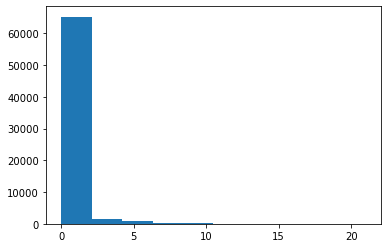

In [34]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

plt.hist(df['comments'].apply(lambda x: len(x['authors'])))

In [49]:
comments.values

array([{'authors': ['GGAF'], 'texts': ['cool'], 'datetimes': [datetime.datetime(2019, 9, 16, 17, 5)]},
       {'authors': ['piyushp7879', 'aanthony-jegu', 'ppukamakara', 'sixam'], 'texts': ['Nice', 'This is great work, great models and the support from the team Sixam is really profesional. I had some issue importing the models correctly in C4D and they helped me within the hour. So yes Highly recommended. ', 'Gorgeous', 'Thank you for your feedback. :)'], 'datetimes': [datetime.datetime(2019, 8, 1, 3, 36), datetime.datetime(2019, 10, 31, 13, 46), datetime.datetime(2020, 2, 10, 9, 24), datetime.datetime(2020, 2, 10, 9, 47)]},
       {'authors': ['Dolphin-GS'], 'texts': ['Good'], 'datetimes': [datetime.datetime(2018, 1, 25, 4, 46)]},
       ...,
       {'authors': ['PBRCool'], 'texts': ['superb!'], 'datetimes': [datetime.datetime(2018, 11, 2, 4, 49)]},
       {'authors': ['lyivan'], 'texts': ['nice'], 'datetimes': [datetime.datetime(2018, 11, 24, 8, 15)]},
       {'authors': ['Kado3D'], 

In [92]:
model_detail_df = pd.DataFrame(list(df['model_details']))

In [102]:
model_detail_df

binary_cols = ['animated', 'rigged', 'vr/ar/low-poly', 'pbr', 'textures', 'materials', 'uv_mapping', 'plugins_used']

In [106]:
model_detail_df = model_detail_df.dropna()

In [107]:
for col in binary_cols:
    model_detail_df[col] = model_detail_df[col].astype(int)

In [132]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.corpus import stopwords

In [134]:
vectorizer = CountVectorizer(stop_words = stopwords)
transformer = TfidfTransformer()

In [ ]:
trainVectorizerArray = vectorizer.fit_transform(train_set).toarray()
testVectorizerArray = vectorizer.transform(test_set).toarray()

In [110]:
# importing one hot encoder 
from sklearn.preprocessing import OneHotEncoder
# creating one hot encoder object 
ohe = OneHotEncoder()

In [116]:
ohe.fit_transform(model_detail_df[['unwrapped_uvs', 'geometry']].values.reshape(-1, 1)).toarray()

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [118]:
model_detail_df['geometry'].value_counts()

Polygon mesh            47652
-                        9578
Subdivision ready        1613
Subdivision              1572
Other                    1153
Nurbs                     243
Polygon                   181
Choose Geometry           111
                            5
选择几何                        2
Выбрать геометрию           2
Odaberite Geometriju        1
Elige La Geometría          1
Name: geometry, dtype: int64

In [122]:
valid_df = model_detail_df.drop(['model_id', 'geometry', 'unwrapped_uvs'], axis=1)

In [149]:
pretext_df = pd.merge(df.iloc[valid_df.index, :].drop(['modeler', 'model_description', 'modeler_response', 'response_time', 'modeler_ratings', 'tags', 'comments', 'price', 'model_details'], axis=1), valid_df, left_index=True, right_index=True)

In [150]:
pretext_df.head()

,views,likes,review_count,pic_count,price_usd,tag_count,cleaned_text,polygons,vertices,animated,rigged,vr/ar/low-poly,pbr,textures,materials,uv_mapping,plugins_used
0,351,0,0,30,6.0,7,high quality 3d models of barazza the models a...,273224,365483,0,0,1,0,1,1,1,0
0,170,0,0,2,4.0,6,cast iron plantsorry i don t know how to expor...,273224,365483,0,0,1,0,1,1,1,0
0,103,1,0,6,12.0,16,coffee table tray rimadesio dimensions w x d x...,273224,365483,0,0,1,0,1,1,1,0
0,43,1,0,5,4.0,15,chicken turkey leg thigh photogrammetry 3d mod...,273224,365483,0,0,1,0,1,1,1,0
0,1330,2,0,25,179.0,20,highly detailed 3d model of a hospital hallway...,273224,365483,0,0,1,0,1,1,1,0


In [117]:
ohe.categories_

[array(['', '- ', 'Choose Geometry', 'Elige La Geometría', 'Mixed', 'No',
        'Non-overlapping', 'Nurbs', 'Odaberite Geometriju', 'Other',
        'Overlapping', 'Polygon', 'Polygon mesh', 'Subdivision',
        'Subdivision ready', 'Unknown', 'Выбрать геометрию', '选择几何'],
       dtype=object)]

In [108]:
model_detail_df

,model_id,geometry,polygons,vertices,unwrapped_uvs,animated,rigged,vr/ar/low-poly,pbr,textures,materials,uv_mapping,plugins_used
0,801556,Subdivision ready,273224,365483,,0,0,1,0,1,1,1,0
1,2095846,Polygon mesh,389886,395824,Unknown,0,0,0,0,1,1,0,1
2,2418972,Polygon mesh,34752,17630,Non-overlapping,0,0,0,0,1,1,1,0
3,2372429,Polygon mesh,236424,241981,No,0,0,0,0,1,1,1,1
4,2251378,Polygon mesh,500000,500000,Mixed,0,0,0,0,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
68034,2252178,Polygon mesh,61852,63731,Mixed,0,0,0,0,1,1,1,1
68035,2029813,-,0,0,Unknown,0,0,0,0,1,1,0,1
68036,904538,Polygon mesh,1501,1460,Non-overlapping,0,0,1,0,1,0,1,0
68037,2003192,-,20471,20278,No,0,0,0,0,1,1,1,1


In [55]:
# probably drop all 0/0 rows
model_detail_df[model_detail_df['materials'].isna()]

,model_id,geometry,polygons,vertices,unwrapped_uvs,animated,rigged,vr/ar/low-poly,pbr,textures,materials,uv_mapping,plugins_used
5,34572,-,0,0,Unknown,False,False,False,False,NaN,NaN,NaN,NaN
13,142530,Polygon mesh,0,0,Unknown,False,False,False,False,NaN,NaN,NaN,NaN
36,137245,Polygon mesh,0,0,Unknown,False,False,False,False,NaN,NaN,NaN,NaN
37,30707,-,0,0,Unknown,False,False,False,False,NaN,NaN,NaN,NaN
48,35740,-,0,0,Unknown,False,False,False,False,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
67928,208974,-,0,0,Unknown,False,False,False,False,NaN,NaN,NaN,NaN
67975,155632,Polygon mesh,0,0,Unknown,False,False,False,False,NaN,NaN,NaN,NaN
67992,151621,-,0,0,Unknown,False,False,False,False,NaN,NaN,NaN,NaN
68022,133154,Polygon mesh,0,0,Unknown,False,False,False,False,NaN,NaN,NaN,NaN


In [61]:
sum(model_detail_df['polygons'] == 0)

20035

In [62]:
sum(model_detail_df['vertices'] == 0)

22651

In [73]:
test = set(model_detail_df[model_detail_df['vertices'] == 0].index)
test.update(list(set(model_detail_df[model_detail_df['polygons'] == 0].index)))

In [84]:
better_df = model_detail_df.drop(list(test))

In [86]:
better_df.iloc[0, 4]

''

In [58]:
model_detail_df.where(~(model_detail_df.polygons == 0.0) & (model_detail_df.vertices == 0.0))

,model_id,geometry,polygons,vertices,unwrapped_uvs,animated,rigged,vr/ar/low-poly,pbr,textures,materials,uv_mapping,plugins_used
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
68034,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68035,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68036,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
model_detail_df['materials'].apply(lambda x: {True: 1, False: 0}[x])

KeyError: nan

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.9, max_features=200000,
                                 min_df=0.1, stop_words=stopwords,
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

tfidf_matrix = tfidf_vectorizer.fit_transform(df.model_description.values) #fit the vectorizer to synopses

print(tfidf_matrix.shape)